In [1]:
import os
import shutil
import cv2
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.python.framework.ops import get_resource_handle_data

In [23]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6836073541105234813
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1721342363
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13022756502715602162
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
metadata = pd.read_csv("./data/HAM10000_metadata.csv")
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [25]:
diagnosis_type = metadata.dx.unique()
data_path = "./data/images"
for type in diagnosis_type:
    path = os.path.join(data_path,type)
    os.makedirs(path,exist_ok=True)
os.listdir("./data/")

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'images']

In [26]:
diagnose = metadata.loc[metadata["image_id"] == "ISIC_0027419"]["dx"].values[0]
diagnose

'bkl'

In [27]:
os.listdir("./data/HAM10000_images_part_1/")[0][:-4]


'ISIC_0024306'

In [28]:
image_list = os.listdir("./data/HAM10000_images_part_2/")
for image in tqdm(image_list):
    shutil.copy(f"./data/HAM10000_images_part_2/{image}",f'./data/images/{metadata.loc[metadata["image_id"] == image[:-4]]["dx"].values[0]}')

100%|██████████| 5015/5015 [00:09<00:00, 519.11it/s]


In [3]:
image_data = tf.keras.preprocessing.image_dataset_from_directory("./data/images/",label_mode="categorical")

Found 10015 files belonging to 7 classes.


In [9]:
image_data_iterator = image_data.as_numpy_iterator()
image_data_iterator
batch = image_data_iterator.next()
batch


(array([[[[166.83014 ,  99.31506 , 106.852905],
          [178.52533 , 107.54309 , 112.29071 ],
          [182.07867 , 112.098206, 114.78735 ],
          ...,
          [ 70.78961 ,  33.777893,  45.47711 ],
          [ 66.7912  ,  30.761597,  42.30847 ],
          [ 52.689514,  21.445312,  34.327454]],
 
         [[171.48627 , 105.189514, 111.49609 ],
          [184.97943 , 115.23511 , 117.1275  ],
          [186.98438 , 117.371704, 119.537415],
          ...,
          [ 80.57587 ,  38.93524 ,  50.42865 ],
          [ 73.47052 ,  32.324585,  46.318176],
          [ 58.48047 ,  25.197205,  37.046997]],
 
         [[176.73547 , 110.73547 , 113.53345 ],
          [188.63898 , 120.60773 , 119.83429 ],
          [195.16174 , 122.65393 , 124.98132 ],
          ...,
          [ 85.5777  ,  43.867188,  51.177673],
          [ 75.1803  ,  34.930725,  46.214233],
          [ 61.733826,  26.637268,  39.118835]],
 
         ...,
 
         [[ 78.14679 ,  32.599365,  41.034607],
          [ 84.103

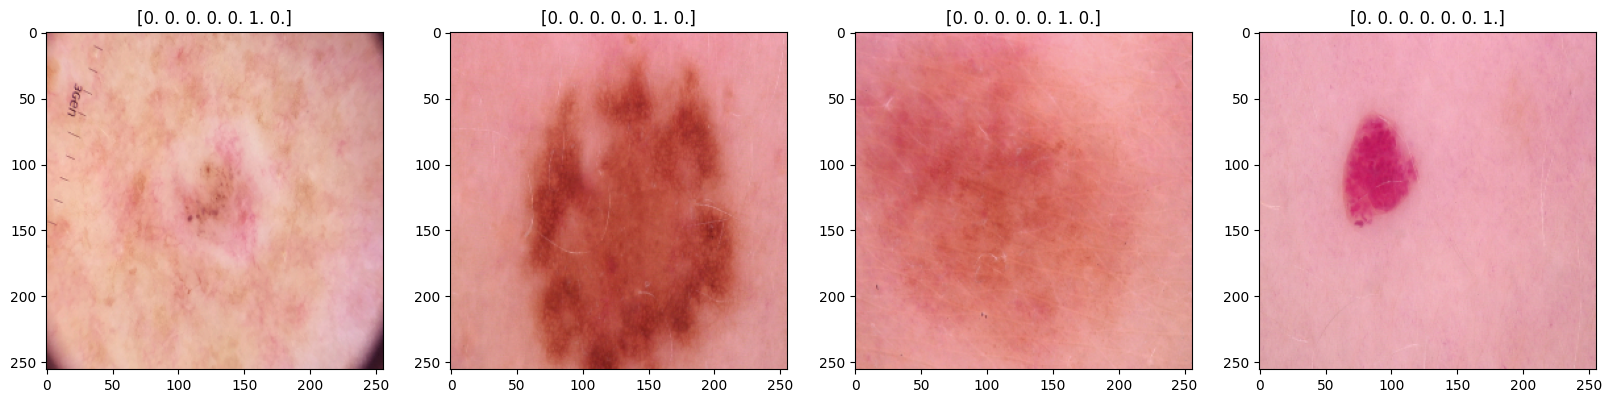

In [10]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



In [11]:
batch[0].max()/255

1.0

In [12]:
scaled_image_data = image_data.map(lambda x,y:(x/255,y))

In [13]:
train_size = int(len(scaled_image_data)*0.7)
validation_size = int(len(scaled_image_data)*0.2)
test_size = int(len(scaled_image_data)*0.1)
train_size,validation_size,test_size

(219, 62, 31)

In [14]:
train = scaled_image_data.take(train_size)
validation = scaled_image_data.skip(train_size).take(validation_size)
test = scaled_image_data.skip(train_size+validation_size).take(test_size)

In [36]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [77]:
model = Sequential()

In [78]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))


In [79]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy',tf.keras.metrics.Precision()])

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)       

In [81]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=10, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/10
219/219 [==============================] - 29s 127ms/step - loss: 1.0353 - accuracy: 0.6608 - precision_1: 0.7750 - val_loss: 0.9889 - val_accuracy: 0.6779 - val_precision_1: 0.8208
Epoch 2/10
219/219 [==============================] - 27s 124ms/step - loss: 0.9208 - accuracy: 0.6709 - precision_1: 0.8156 - val_loss: 0.9684 - val_accuracy: 0.6779 - val_precision_1: 0.8646
Epoch 3/10
219/219 [==============================] - 27s 125ms/step - loss: 0.8743 - accuracy: 0.6858 - precision_1: 0.8182 - val_loss: 0.8767 - val_accuracy: 0.6996 - val_precision_1: 0.8207
Epoch 4/10
219/219 [==============================] - 27s 123ms/step - loss: 0.8495 - accuracy: 0.6898 - precision_1: 0.8238 - val_loss: 0.8597 - val_accuracy: 0.7016 - val_precision_1: 0.8448
Epoch 5/10
219/219 [==============================] - 27s 123ms/step - loss: 0.7925 - accuracy: 0.7132 - precision_1: 0.8299 - val_loss: 0.8686 - val_accuracy: 0.7056 - val_precision_1: 0.8608
Epoch 6/10
219/219 [===============

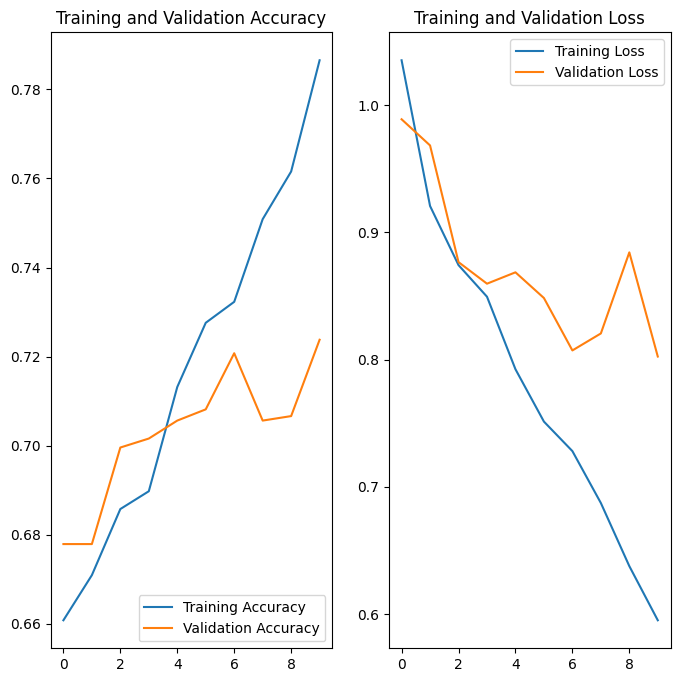

In [82]:
epochs = 10
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
import numpy as np
np.argmax(model.predict(test))

31/31 [==============================] - 6s 34ms/step


6606

In [28]:
prediction = model.predict(test)

31/31 [==============================] - 6s 31ms/step


In [31]:
np.argmax(prediction[0])

5

In [83]:
classes = {0:"akiec",
           1:"bcc",
           2:"bkl",
           3:"df",
           4:"mel",
           5:"nv",
           6:"vasc"}

In [36]:
prediction.shape

(992, 7)

In [38]:
classes[np.argmax(prediction[500])]

'nv'

In [39]:
prediction_results = []
for i in range(len(prediction)):
    prediction_results.append(classes[np.argmax(prediction[i])])

In [41]:
prediction_results = pd.Series(prediction_results)

In [42]:
prediction_results.value_counts()

nv       767
bkl      105
bcc       61
mel       37
vasc      12
akiec      9
df         1
dtype: int64

In [84]:
from matplotlib import image
newpred = []
images = os.listdir("./data/images/nv/")
for imagen in tqdm(images):
    test_image = cv2.imread(f"./data/images/nv/{imagen}")
    test_image = cv2.resize(test_image,(256,256))
    
    newpred.append(np.argmax(model.predict(np.expand_dims(test_image,axis=0),verbose=0)))
    
newpred = pd.Series(newpred)
newpred.value_counts()

100%|██████████| 6705/6705 [06:54<00:00, 16.19it/s]


5    3375
1    3312
6      16
2       1
0       1
dtype: int64

5    782
1    314
0      3
dtype: int64

In [51]:
test_image.shape

(450, 600, 3)

In [56]:
from PIL import Image

om = np.resize(test_image,(256,256,3))

In [58]:
om

array([[[167, 137, 165],
        [171, 136, 169],
        [171, 136, 169],
        ...,
        [199, 160, 189],
        [200, 161, 192],
        [194, 155, 186]],

       [[197, 158, 189],
        [205, 168, 201],
        [203, 166, 199],
        ...,
        [193, 159, 186],
        [193, 158, 190],
        [193, 158, 190]],

       [[194, 159, 189],
        [196, 159, 190],
        [194, 159, 189],
        ...,
        [199, 159, 193],
        [197, 158, 189],
        [197, 157, 191]],

       ...,

       [[195, 161, 194],
        [198, 162, 198],
        [199, 161, 198],
        ...,
        [189, 136, 154],
        [193, 138, 157],
        [191, 138, 156]],

       [[190, 138, 151],
        [195, 144, 163],
        [195, 142, 162],
        ...,
        [189, 145, 172],
        [191, 145, 174],
        [192, 146, 172]],

       [[194, 146, 168],
        [194, 150, 175],
        [191, 151, 177],
        ...,
        [189, 135, 161],
        [190, 136, 159],
        [190, 136, 159]]

In [61]:
np.argmax(model.predict(np.expand_dims(om,axis=0)))

1/1 [==============================] - 0s 17ms/step


5